# Connect4 Lookahead — Sanity Checks

This notebook runs quick, reproducible head‑to‑head matches to verify that **Lookahead** behaves as expected:
- Random vs L1 (L1 should dominate);
- L1 vs L2 (L2 should do better);
- L2 vs L3 (L3 should do better).

You can also choose any two players (Random or fixed depth) and play *N* games.

In [1]:
import os, sys, types, importlib.util, random, math
import numpy as np
import matplotlib.pyplot as plt

# --- Attempt normal project imports first ---
try:
    from C4.connect4_env import Connect4Env
    from C4.fast_connect4_lookahead import Connect4Lookahead
    PROJECT_IMPORTS_OK = True
except Exception as e:
    print("[info] Project-style imports failed, enabling local fallbacks:", e)
    PROJECT_IMPORTS_OK = False

    # Create a dummy 'C4' package in sys.modules
    if 'C4' not in sys.modules:
        C4 = types.ModuleType("C4")
        C4.__path__ = []
        sys.modules['C4'] = C4

    def _load_module_at(name, path):
        spec = importlib.util.spec_from_file_location(name, path)
        mod = importlib.util.module_from_spec(spec)
        sys.modules[name] = mod
        spec.loader.exec_module(mod)
        return mod

    # Try to locate files in current working dir or /mnt/data
    search_paths = [os.getcwd(), "/mnt/data"]
    def _find(fname):
        for p in search_paths:
            cand = os.path.join(p, fname)
            if os.path.exists(cand):
                return cand
        raise FileNotFoundError(fname)

    # Load fast_connect4_lookahead.py and register as C4.fast_connect4_lookahead
    fast_path = _find("fast_connect4_lookahead.py")
    _load_module_at("C4.fast_connect4_lookahead", fast_path)
    from C4.fast_connect4_lookahead import Connect4Lookahead

    # Load connect4_env.py as C4.connect4_env (it imports C4.fast_connect4_lookahead)
    env_path = _find("connect4_env.py")
    _load_module_at("C4.connect4_env", env_path)
    from C4.connect4_env import Connect4Env

print("Imports ready. Connect4Env:", Connect4Env, "| Connect4Lookahead:", Connect4Lookahead)

Imports ready. Connect4Env: <class 'C4.connect4_env.Connect4Env'> | Connect4Lookahead: <class 'C4.fast_connect4_lookahead.Connect4Lookahead'>


In [2]:
from dataclasses import dataclass

@dataclass(frozen=True)
class PlayerSpec:
    kind: str   # "Random" or "Lk" where k is int (e.g., "L1", "L2", "L3")
    depth: int  # 0 for Random, else fixed lookahead depth

def parse_player(spec: str) -> PlayerSpec:
    s = spec.strip().lower()
    if s in ("random", "r", "rand"):
        return PlayerSpec(kind="Random", depth=0)
    if s.startswith("lookahead-"):
        k = int(s.split("-")[1])
        return PlayerSpec(kind=f"L{k}", depth=k)
    if s.startswith("l") and s[1:].isdigit():
        k = int(s[1:])
        return PlayerSpec(kind=f"L{k}", depth=k)
    raise ValueError(f"Unrecognized player spec: {spec!r}")

class RandomPolicy:
    def __call__(self, env):
        return random.choice(env.available_actions())

class LookaheadPolicy:
    def __init__(self, depth:int):
        self.depth = int(depth)
        self.LA = Connect4Lookahead()

    def __call__(self, env):
        board = env.board   # top-based {+1,0,-1}
        a = self.LA.n_step_lookahead(board, player=env.current_player, depth=self.depth)
        if a not in env.available_actions():
            # extremely rare fallback
            a = random.choice(env.available_actions())
        return a

def make_policy(player_spec: PlayerSpec):
    if player_spec.kind == "Random":
        return RandomPolicy()
    else:
        return LookaheadPolicy(player_spec.depth)

def short_name(ps: PlayerSpec) -> str:
    return ps.kind if ps.kind == "Random" else f"L{ps.depth}"

In [3]:
def play_single_game(A_policy, B_policy, A_color=+1, seed=None):
    '''
    Returns A's score: 1 for A win, 0.5 draw, 0 for A loss.
    Alternates who starts by setting env.current_player before the first move.
    '''
    if seed is not None:
        random.seed(seed); np.random.seed(seed)

    env = Connect4Env()
    env.reset()
    env.current_player = A_color  # +1 → A starts, -1 → B starts

    done = False
    while not done:
        if env.current_player == +1:  # A to move (if colors as set)
            a = A_policy(env)
        else:
            a = B_policy(env)
        _, _, done = env.step(a)

    if env.winner == +1:
        return 1.0
    if env.winner == -1:
        return 0.0
    return 0.5

def run_series(A_spec: str, B_spec: str, n_games: int = 200, seed: int = 123):
    '''
    Play n_games; alternate who starts to offset first-move advantage.
    Returns dict with counts and score rate for A.
    '''
    Aps = parse_player(A_spec)
    Bps = parse_player(B_spec)
    A_pol = make_policy(Aps)
    B_pol = make_policy(Bps)

    rng = random.Random(seed)
    colors = ([+1, -1] * ((n_games + 1)//2))[:n_games]

    wins = draws = losses = 0
    timeline = []
    for i, A_color in enumerate(colors):
        s = play_single_game(A_pol, B_pol, A_color=A_color, seed=rng.randint(0, 10**9))
        timeline.append(s)
        if s == 1.0: wins += 1
        elif s == 0.5: draws += 1
        else: losses += 1

    n = len(timeline)
    score = (wins + 0.5*draws) / n if n else 0.0

    return {
        "A": short_name(Aps),
        "B": short_name(Bps),
        "games": n,
        "A_wins": wins, "draws": draws, "A_losses": losses,
        "A_score_rate": score,
        "timeline": timeline,
    }

def mean_ci(scores, z=1.96):
    '''CI for mean of scores in {0, 0.5, 1}. Normal approximation.'''
    x = np.asarray(scores, float)
    n = len(x)
    m = float(x.mean()) if n else 0.0
    s = float(x.std(ddof=1)) if n > 1 else 0.0
    half = z * s / (n ** 0.5) if n > 1 else 0.0
    return (max(0.0, m - half), min(1.0, m + half))

def plot_stacked_bar(res):
    n   = res["games"]
    pw  = res["A_wins"] / n
    pd  = res["draws"]  / n
    pl  = res["A_losses"]/ n
    title = f'{res["A"]} vs {res["B"]}'

    fig, ax = plt.subplots(figsize=(6.5, 1.6))
    left = 0.0
    ax.barh([0], [pw], left=left, label="Win")
    left += pw
    ax.barh([0], [pd], left=left, label="Draw")
    left += pd
    ax.barh([0], [pl], left=left, label="Loss")
    ax.set_xlim(0, 1); ax.set_yticks([]); ax.set_xlabel("Proportion")
    ax.set_title(f"{title} — A Win/Draw/Loss")
    ax.legend(ncols=3, loc="lower right", frameon=False)
    pos = 0.0
    for frac, text in [(pw, f"W {res['A_wins']}"), (pd, f"D {res['draws']}"), (pl, f"L {res['A_losses']}")]:
        if frac > 0:
            ax.text(pos + frac/2, 0, text, ha="center", va="center", color="white", fontsize=10)
            pos += frac
    plt.tight_layout()
    plt.show()

In [4]:
# --- Parameters ---
N_GAMES   = 200
PLAYER_A  = "L1"       # options: "Random", "L1", "L2", "L3", ... or "Lookahead-1"
PLAYER_B  = "Random"
SEED      = 123
print("Configured:", N_GAMES, PLAYER_A, "vs", PLAYER_B)

Configured: 200 L1 vs Random


L1 vs Random: games=200  A_score=1.000  CI95=(1.000, 1.000)
Counts: W=200, D=0, L=0


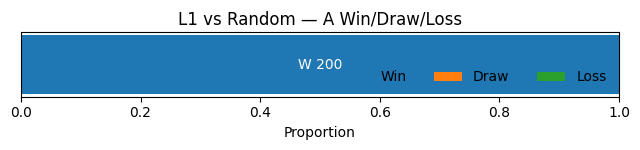

In [5]:
res = run_series(PLAYER_A, PLAYER_B, n_games=N_GAMES, seed=SEED)
lo, hi = mean_ci(res["timeline"], z=1.96)
print(f'{res["A"]} vs {res["B"]}: games={res["games"]}  A_score={res["A_score_rate"]:.3f}  CI95=({lo:.3f}, {hi:.3f})')
print(f'Counts: W={res["A_wins"]}, D={res["draws"]}, L={res["A_losses"]}')
plot_stacked_bar(res)

[L1 beats Random] score=1.000  CI95=(1.000, 1.000)  -> PASS


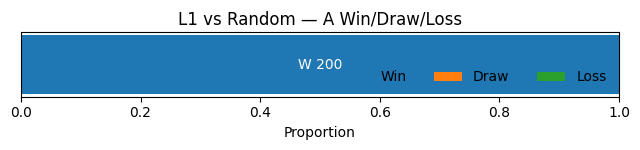

[L2 beats L1] score=0.733  CI95=(0.674, 0.791)  -> PASS


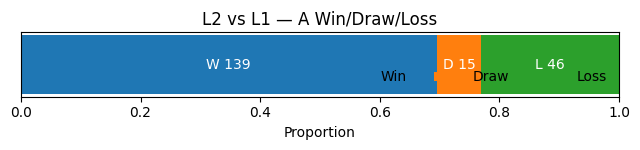

[L3 beats L2] score=0.405  CI95=(0.358, 0.452)  -> FAIL


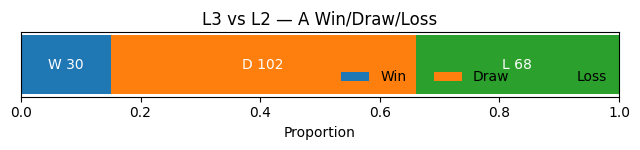

AssertionError: L3 beats L2 not satisfied at n=200 (score=0.405, CI95=(0.358, 0.452))

In [6]:
def assert_stronger(A, B, n_games=200, seed=123, thresh=0.55, label=None):
    res = run_series(A, B, n_games=n_games, seed=seed)
    lo, hi = mean_ci(res["timeline"], z=1.96)
    ok = (res["A_score_rate"] >= thresh) and (lo > 0.5)
    tag = label or f"{res['A']} > {res['B']}"
    print(f"[{tag}] score={res['A_score_rate']:.3f}  CI95=({lo:.3f}, {hi:.3f})  -> {'PASS' if ok else 'FAIL'}")
    plot_stacked_bar(res)
    assert ok, f"{tag} not satisfied at n={n_games} (score={res['A_score_rate']:.3f}, CI95=({lo:.3f}, {hi:.3f}))"

# --- Default sanity suite ---
TESTS = [
    ("L1", "Random",  200, 0.60, "L1 beats Random"),
    ("L2", "L1",      200, 0.55, "L2 beats L1"),
    ("L3", "L2",      200, 0.55, "L3 beats L2"),
]

for A, B, n, t, label in TESTS:
    assert_stronger(A, B, n_games=n, seed=SEED, thresh=t, label=label)

print("✅ All lookahead sanity assertions passed.")

## Improvements: clearer bars + non‑fatal checks

- Bars now show **percentages** and **counts** inside each segment.
- `check_stronger()` prints PASS/FAIL without raising, so the run never crashes.
- Added a small **depth/seed sweep** cell to help diagnose anomalies (e.g., L3 underperforming L2).

In [ ]:
# Improved plot with proportions (percent labels + counts)
def plot_stacked_bar_pretty(res):
    n   = res["games"]
    pw  = res["A_wins"] / n if n else 0
    pd  = res["draws"]  / n if n else 0
    pl  = res["A_losses"]/ n if n else 0
    title = f'{res["A"]} vs {res["B"]}'
    segs = [("Win", pw, res["A_wins"]), ("Draw", pd, res["draws"]), ("Loss", pl, res["A_losses"])]

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(6.5, 1.6))
    left = 0.0
    for name, frac, cnt in segs:
        ax.barh([0], [frac], left=left, label=name)
        if frac > 0:
            ax.text(left + frac/2, 0, f"{name[0]} {cnt}  ({frac*100:.1f}%)",
                    ha="center", va="center", color="white", fontsize=10)
        left += frac

    ax.set_xlim(0, 1); ax.set_yticks([]); ax.set_xlabel("Proportion")
    ax.set_title(f"{title} — A Win/Draw/Loss")
    ax.legend(ncols=3, loc="lower right", frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
# Non-fatal checker: prints PASS/FAIL without assert
def check_stronger(A, B, n_games=200, seed=123, thresh=0.55, label=None):
    res = run_series(A, B, n_games=n_games, seed=seed)
    lo, hi = mean_ci(res["timeline"], z=1.96)
    ok = (res["A_score_rate"] >= thresh) and (lo > 0.5)
    tag = label or f"{res['A']} > {res['B']}"
    verdict = "PASS ✅" if ok else "FAIL ❌"
    print(f"[{tag}] score={res['A_score_rate']:.3f}  CI95=({lo:.3f}, {hi:.3f})  -> {verdict}")
    plot_stacked_bar_pretty(res)
    return {"label": tag, "ok": ok, **res, "CI95": (lo, hi)}

In [ ]:
# Example: run the three checks again without crashing
RESULTS = []
RESULTS.append(check_stronger("L1", "Random", n_games=200, seed=SEED, thresh=0.60, label="L1 beats Random"))
RESULTS.append(check_stronger("L2", "L1",     n_games=200, seed=SEED, thresh=0.55, label="L2 beats L1"))
RESULTS.append(check_stronger("L3", "L2",     n_games=200, seed=SEED, thresh=0.55, label="L3 beats L2"))
RESULTS

In [ ]:
# Quick diagnostic sweep: multiple seeds, depths, shorter series
def sweep_depths(pairs, seeds=5, games=100):
    rows = []
    for (A, B) in pairs:
        wins = draws = losses = 0
        for s in range(seeds):
            res = run_series(A, B, n_games=games, seed=1000 + s)
            wins  += res["A_wins"]
            draws += res["draws"]
            losses+= res["A_losses"]
        n = seeds * games
        score = (wins + 0.5*draws) / n if n else 0.0
        rows.append({
            "A": A, "B": B, "games": n,
            "A_win%": wins/n, "draw%": draws/n, "A_loss%": losses/n,
            "A_score": score
        })
    import pandas as pd
    df = pd.DataFrame(rows)
    return df.sort_values("A_score", ascending=False).reset_index(drop=True)

pairs = [("L1","Random"), ("L2","L1"), ("L3","L2"), ("L3","L1"), ("L2","Random"), ("L3","Random")]
diag = sweep_depths(pairs, seeds=6, games=100)
import caas_jupyter_tools as cj
cj.display_dataframe_to_user("Lookahead depth diagnostic", diag)
diag